In [9]:
import pandas as pd 
import numpy as np 
from scipy.optimize import minimize 
import matplotlib.pyplot as plt 
from utiles import * 
df = pd.read_csv('ARP_Returns.csv')
df_norm, df_return = cal_return(df)

In [10]:
settings = [
            ('2009-01-01', 1, None, 'diversification_ratio'), 
            # ('2015-09-01', 1, None),
            # ('2017-09-01', 1, None),
            # ('2009-01-01', 0.1, None),
            # ('2015-09-01', 0.1, None),
            # ('2017-09-01', 0.1, None),
            # ('2009-01-01', 1, 'equity_trend'), 
            # ('2015-09-01', 1, 'equity_trend'),
            # ('2017-09-01', 1, 'equity_trend'),
            # ('2009-01-01', 0.1, 'equity_trend'),
            # ('2015-09-01', 0.1, 'equity_trend'),
            # ('2017-09-01', 0.1, 'equity_trend')
           ]

result = {} 

('2009-01-01', 1, None, 'diversification_ratio')
CPU times: user 22.1 s, sys: 123 ms, total: 22.2 s
Wall time: 22.3 s


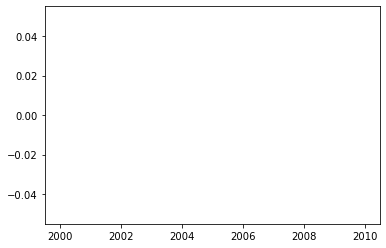

In [11]:
%%time
for config in settings:
    print(config)
    result[config] = portfolio_optimisation(df_return, 
                                            cutoff_date=config[0],
                                            upper_bound=config[1],
                                            drop_strategy=config[2],
                                            target=config[3])

In [12]:
result[config]['diversification_ratio']

3.7488137856472226

In [13]:
result[config]['weights'] * 100 

array([ 1.76104235,  8.86988439, 10.02841733,  0.26106946,  3.37448112,
       11.32556358,  4.5469082 ,  2.15447006,  4.36658577, 20.55260031,
        6.42375302,  2.46190367,  2.97914461,  1.48805365,  2.40199552,
        0.92569009,  1.29982709,  1.58745773, 10.12842369,  3.06272836])

In [17]:
# rebalance
(1+result[config]['df_return'].set_index('Date')).cumprod()

,equity_momentum,equity_low_beta,equity_quality,commodity_carry,commodity_curve,credit_curve,credit_carry,fx_carry,fx_value,interest_rate_spread,interest_rate_curve,equity_trend,fx_trend,commodity_trend,interest_rate_trend,commodity_volatility_carry,interest_rate_volatility_carry,equity_volatility_carry,cot,merger_arb
Date,,,,,,,,,,,,,,,,,,,,
2009-03-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-03-05,1.000640,1.000696,0.999814,1.008747,1.002183,0.993938,1.004544,1.001736,1.000148,1.001072,0.995755,1.006011,1.001704,1.011168,0.999600,1.000744,0.998926,0.994689,1.000060,0.999984
2009-03-06,0.999571,1.000928,1.000186,1.013598,1.003391,1.000037,1.001630,1.000826,1.000749,1.001118,0.991215,1.008337,1.000391,1.003091,0.997835,1.005800,1.003927,0.994048,1.000515,1.000112
2009-03-09,1.000744,0.995795,0.998880,1.008149,1.001202,0.999429,1.007124,1.004344,0.999320,1.000045,0.989654,1.010600,1.000139,0.998255,0.994950,1.015965,1.008537,0.993567,0.999796,0.999948
2009-03-10,1.000851,0.992769,0.998787,1.008454,1.004918,1.001276,1.010190,1.003396,0.999898,0.999049,0.987763,0.999741,0.996165,0.986373,0.997079,1.024989,1.012432,0.993247,1.000823,1.000702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-01,0.990778,1.100380,0.926583,0.781805,1.155030,1.148030,1.246200,1.183599,1.129365,1.022802,0.956588,0.831396,0.852818,0.612151,1.498891,2.025878,1.423848,1.687066,1.286686,1.226031
2020-10-02,0.991837,1.101418,0.926212,0.784720,1.155807,1.147887,1.244703,1.185596,1.133347,1.022798,0.956973,0.830159,0.853497,0.619138,1.498755,2.015024,1.422941,1.689509,1.285760,1.224998
2020-10-05,0.992578,1.100841,0.925748,0.780583,1.156617,1.148084,1.245549,1.184104,1.130951,1.022731,0.958665,0.831804,0.856705,0.609423,1.498537,2.016974,1.419648,1.692258,1.287256,1.224325
